# Private-Key Encryption Ciphers

In [1]:
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import math
import json
import requests
import string
import difflib

## Shift Cipher

The Shift Cipher, a.k.a. Caesar Cipher, is defined as

* $\textbf{M} = \{\text{strings over lowercase English alphabet}\}$

* $\text{Gen}$: choose uniform $k \in \{0, \ldots, 25\}$

* $\text{Enc}_k(m_1 \ldots m_t)$: output $c_1 \ldots c_t$ where $c_i := m_i + k \pmod{26}$

* $\text{Dec}_k(c_1 \ldots c_t)$: output $m_1 \ldots m_t$ where $m_i := c_i - k \pmod{26}$

The **Shift Cipher** is **not secure** as it has only 26 possible keys, i.e. the **key space** has a size of $26$.

Given a ciphertext, try decrypting with every possible key. If ciphertext is long enough, only one possibility will "make sense".

In [2]:
class ShiftCipher:
    '''
    helloworld
    cccccccccc
    ----------
    jgnnqyqtnf
    '''
    
    alphas = string.ascii_lowercase

    def __init__(self, key):
        self.key = key

    def enc(self, text):
        ciphertext = ""
        for m in text:
            c = self.alphas[(self.alphas.find(m) + self.alphas.find(self.key)) % len(self.alphas)]
            ciphertext += c if m in self.alphas else m
        return ciphertext

    def dec(self, ciphertext):
        text = ""
        for c in ciphertext:
            m = self.alphas[(self.alphas.find(c) - self.alphas.find(self.key)) % len(self.alphas)]
            text += m if c in self.alphas else c
        return text

In [3]:
cipher = ShiftCipher('c')
cipher.enc('helloworld')

'jgnnqyqtnf'

In [4]:
cipher.dec(cipher.enc('helloworld'))

'helloworld'

## Vigenère Cipher

In the Vigenère cypher, the key is a string rather than just a single character:

* $\textbf{M} = \{\text{strings over lowercase English alphabet}\}$

* $\text{Gen}$: string $k \in \{k_1, \ldots, k_u\}$ with $k_i \in \textbf{M}$ and length $u$. String is wraped around if $u < t$

* $\text{Enc}_k(m_1 \ldots m_t)$: output $c_1 \ldots c_t$ where $c_i := m_i + k_i \pmod{26}$

* $\text{Dec}_k(c_1 \ldots c_t)$: output $m_1 \ldots m_t$ where $m_i := c_i - k_i \pmod{26}$

The size of the key space $\textbf{K}$ is ${26}^u$, e.g. if a key has a size $u = 14$, then the key space has a size of ${26}^{14} \approx 2^{66}$ which makes a brute-force search expersive or impossilble.

The **Vigenère Cipher** is not secure though, as there are other attack vectors.

In [5]:
class VigenereCipher:
    '''
    tellhimaboutme
    cafecafecafeca
    --------------
    veqpjiredozxoe    
    '''
    
    alphas = string.ascii_lowercase
    
    def __init__(self, key):
        self.key = key

    def enc(self, plaintext):
        ciphertext = ""
        for u, m in enumerate(plaintext):
            k = self.key[u % len(self.key)]
            c = self.alphas[(self.alphas.find(m) + self.alphas.find(k)) % len(self.alphas)]
            ciphertext += c if m in self.alphas else m
        return ciphertext

    def dec(self, ciphertext):
        text = ""
        for u, c in enumerate(ciphertext):
            k = self.key[u % len(self.key)]
            m = self.alphas[(self.alphas.find(c) - self.alphas.find(k)) % len(self.alphas)]
            text += m if c in self.alphas else c
        return text

In [6]:
cipher = VigenereCipher('cafe')
cipher.enc('tellhimaboutme')

'veqpjiredozxoe'

In [7]:
cipher.dec(cipher.enc('tellhimaboutme'))

'tellhimaboutme'

## Variant of the Vigenère Cipher

This variant works with **ASCII plaintext**, **HEX ciphertext** and with **byte-wise XOR** rather than modular addition.

* $\textbf{M}$: printable characters from an ASCII table with decimal values $32 < m_i < 127$

* $\text{Gen}$: bytes $b = b_1, \ldots, b_u$ represented in HEX with length $u$ with $b \in [\text{0x00}, \ldots, \text{0xFF}]$. Bytes are wraped around if $u < t$

* $\text{Enc}_b(m_1 \ldots m_t)$: output $c_1 \ldots c_t$ where $c_i := m_i \oplus b_i$

* $\text{Dec}_b(c_1 \ldots c_t)$: output $m_1 \ldots m_t$ where $m_i := c_i \oplus b_i$

In [8]:
class VariantVigenereCipher:
    '''
    Hello!
    0xA1 0x2F 0xA1 0x2F 0xA1 0x2F
    -----------------------------
    0xE9 0x4A 0xCD 0x43 0xCE 0x0E
    '''
    
    def __init__(self, key):
        self.key = key

    def xor(self, a, b):
        b = len(a) // len(b) * b + b[:len(a) % len(b)]                 # repeate b to have same size as a
        return [int(c1, 16) ^ int(c2, 16) for (c1, c2) in zip(a, b)]   # XOR byte wise
        
    def enc(self, plaintext):
        text = [hex(ord(c)) for c in plaintext]
        ciphertext = self.xor(text, self.key)
        return [hex(c) for c in ciphertext]

    def dec(self, ciphertext):
        plaintext = self.xor(ciphertext, self.key)
        return "".join([chr(c) for c in plaintext])


In [9]:
key = ['0xa1', '0x2f']
cipher = VariantVigenereCipher(key)
cipher.enc('Hello!')

['0xe9', '0x4a', '0xcd', '0x43', '0xce', '0xe']

In [10]:
cipher.dec(cipher.enc('Hello!'))

'Hello!'

## Breaking the Vigenère Ciper

The Vigenère Ciper can easily be attacked using plaintext **letter frequencies** (see also https://norvig.com/mayzner.html).

The attack times for the following methods are linear with the key length $L$. Compared with brute-force attack, which is exponential with $L$, this attack is very efficient.

In [11]:
# English ngrams
ngrams = requests.get('https://gist.githubusercontent.com/thomd/3db049eb25c9d175c1c539f17b7d2891/raw/8af7bee0b9c0d61f55faf33bbb9a0dcb2a9424ac/ngrams.json').text
counter = Counter(json.loads(ngrams)['letters'])
english_letter_frequencies = [(c.lower(), counter[c] / counter.total() * 100) for c in sorted(counter)]

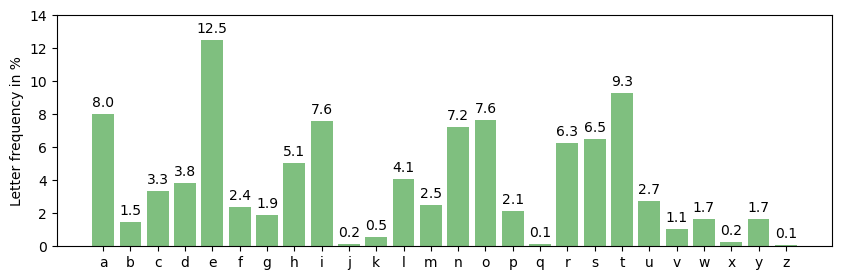

In [12]:
fig, ax = plt.subplots(figsize=(10, 3))
bars = ax.bar([l for l, _ in english_letter_frequencies], [f for _, f in english_letter_frequencies], width=0.8, color='g', alpha=0.5)
plt.ylabel('Letter frequency in %')
plt.ylim(0, 14)
ax.bar_label(bars, fmt='%.1f', padding=3);

In [37]:
most_common = counter.most_common()[0][0]
most_common_english_letter = (most_common.lower(), string.ascii_lowercase.find(most_common.lower()))

print(f'The most common letter is \'{most_common_english_letter[0]}\' with index {most_common_english_letter[1]}')

The most common letter is 'e' with index 4


### Method 1: We know the Key Size

Supposed the key is $n$ characters long

1. look at every $n$<sup>th</sup> character of the cipertext, starting with the first character $[c_0, c_{n}, c_{2n}, \ldots]$.
2. Let $\alpha$ be the most common character appearing in this portion of the cipertext.
3. Most likely this character corresponds to the most common plaintext character 'e'.
4. Guess the first character of the key is $\alpha - \text{e} = \text{index}(\alpha) - 4$.
5. Repeat for all other positions $c_i$ with $i \in [0, \ldots, n]$.

In [14]:
class VigenereCipherAttack:
    alphas = string.ascii_lowercase
    most_common_index = 4

    def restore_key(self, key_length, ciphertext):
        key = ""
        for n in range(key_length):
            counter = Counter(ciphertext[n::key_length])
            a = self.alphas.find(counter.most_common()[0][0])
            key += self.alphas[a - self.most_common_index]
        return key

In [15]:
url = 'https://www.gutenberg.org/cache/epub/4300/pg4300.txt' # The Project Gutenberg eBook of Ulysses
text = [t for t in requests.get(url).text.lower() if t in string.ascii_lowercase] # we want only [a-z]
text = "".join(text)

In [16]:
cipher = VigenereCipher('myverysecretkey')
ciphertext = cipher.enc(text)

Restore the 15 character long key using a cipher text of `1000` characters length:

In [17]:
attack = VigenereCipherAttack()
attack.restore_key(15, ciphertext[:1000])

'wyvormserbntneh'

Restore the key using a cipher text of length `12000` chars:

In [18]:
attack.restore_key(15, ciphertext[:12000])

'myverysecretkey'

Which size of the ciphertext is required to fully restore the 15 characters long key?

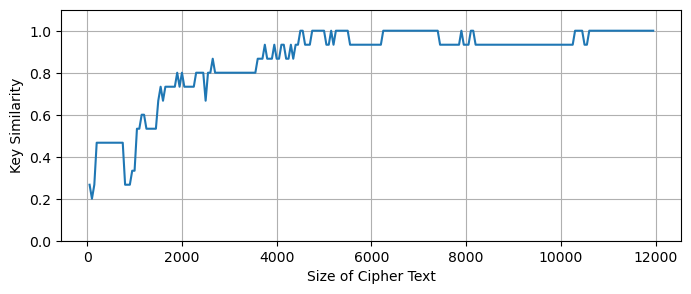

In [19]:
ciphertext_size = []
similarity = []
for s in range(50, 12000, 50):
    restored_key = attack.restore_key(15, ciphertext[:s])
    ciphertext_size.append(s)
    similarity.append(difflib.SequenceMatcher(a='myverysecretkey', b=restored_key).ratio())

plt.subplots(figsize=(8, 3))
plt.ylim(0, 1.1)
plt.grid()
plt.xlabel('Size of Cipher Text')
plt.ylabel('Key Similarity')
plt.plot(ciphertext_size, similarity);

### Method 2: The Key Size is Unknown

Here we use the variant of the Vigenèr cipher.

We first determine the key length and then determine each byte of the key.

In [20]:
class VariantVigenereCipherAttack:

    # Kullback-Leibler divergence for discrete distributions
    def kl(self, p, q):
        p = np.asarray(p)
        q = np.asarray(q)
        return np.sum(np.where(p != 0, p * np.log(p / q), 0))

    def determine_key_length(self, ciphertext, max_key_length=40):
        L2norms = []
        for n in range(1, max_key_length):
            counter = Counter([c for c in ciphertext[::n]])
            L2norm = math.sqrt(sum([(counter[c] / counter.total()) ** 2 for c in counter]))
            L2norms.append((L2norm, n))
        return sorted(L2norms, reverse=True)[0][1], L2norms
    
    def restore_key(self, key_length, ciphertext):
        key = ""
        for k in range(key_length):
            candidates = []
            for i in range(256):
                cipher_stream = ciphertext[:1000][k::key_length]
                plaintext_stream = [int(c1, 16) ^ int(c2, 16) for (c1, c2) in zip(cipher_stream, [hex(i)]*len(cipher_stream))]
                if all([s in range(32, 127) for s in plaintext_stream]):
                    counter = Counter([s for s in plaintext_stream if s in range(97, 123)])
                    counter.update(dict([(a,0.0001) for a in range(97, 123)]))
                    s = counter.total()
                    letters = sorted(counter)
                    frequencies = [counter[c] / s * 100 for c in letters]
                    kld = self.kl(frequencies, [f for _, f in english_letter_frequencies])
                    candidates.append((kld, i))
                    
            # we use the candidate which letter distribution is most equal to the english letter frequency distribution
            key += chr(sorted(candidates)[0][1])
        return key

#### Determine the Key Length

1. Let $p_i$ for $0 \leq i \leq 255$ the frequency of byte $i$ in plaintext with $p_i = 0$ for $i < 32$ and $i > 126$ (these are non printable characters)

2. If the key length is $N$, then every $N$<sup>th</sup> character of thr plaintext is encryptes using the same "shift".

3. If we take every $N$<sup>th</sup> character and calculate the freuqencies, we should get all $p_i$ in **permuted order**.

4. If we take every $M$<sup>th</sup> character (with $M$ not a multiple of $N$) and calculate the freuqencies, we should get something close to **unifom** (heuristically speaking).

5. Calculate the **L2 norm** of each key-length distribution. The L2 norm of a **uniform** probability distribution is always **smaller** as of a **non-uniform** distribution.

6. Pick the largest value for the L2 norm to identify $N$.

<br><br>

**Prove** *The L2 norm of a uniform probability distribution is always smaller as of a non-uniform distribution*:

For a probability distribution $p = [p_1, \ldots, p_n]$ with $\sum p_i = 1$, the **L2 norm** is 

$$\|p\|_2 = \sqrt{p_1^2 + \ldots + p_n^2}$$

Now consider a **uniform** probability distribution $u = [\frac{1}{n}, \ldots, \frac{1}{n}]$, then we have 

$$\|u\|_2 = \sqrt{n \cdot \frac{1}{n^2}} = \frac{1}{\sqrt{n}}$$

By the **Cauchy-Schwarz Inequality** we have:

$$\Big(\sum{}a_i b_i\Big)^2 \leq \sum{}a_i^2 \cdot \sum{}b_i^2$$

Let $a_i = p_i$ and $b_i = \frac{1}{n}$. Then

$$
\begin{align}
\Big(\sum{p_i \frac{1}{n}}\Big)^2 &\leq \sum{}p_i^2 \cdot \sum{}\frac{1}{n^2} \\[5pt]
\Big(\frac{1}{n}\Big)^2 &\leq \sum{}p_i^2 \cdot \frac{1}{n} \\[5pt]
\frac{1}{n} &\leq \sum{}p_i^2 \\[5pt]
\frac{1}{\sqrt{n}} &\leq \sqrt{\sum{}p_i^2} \\[9pt]
\|u\|_2 &\leq \|p\|_2
\end{align}
$$

In [21]:
url = 'https://www.gutenberg.org/cache/epub/4300/pg4300.txt' # The Project Gutenberg eBook of Ulysses
text = [t for t in requests.get(url).text if ord(t) in list(range(32, 127))] # we want only printable ASCII characters
text = "".join(text)

In [22]:
cipher = VariantVigenereCipher([hex(ord(c)) for c in 'a very secret key'])
ciphertext = cipher.enc(text)

In [23]:
attack = VariantVigenereCipherAttack()
determined_key_length, L2norms = attack.determine_key_length(ciphertext)

print(f'Determined key length: {determined_key_length}')

Determined key length: 17


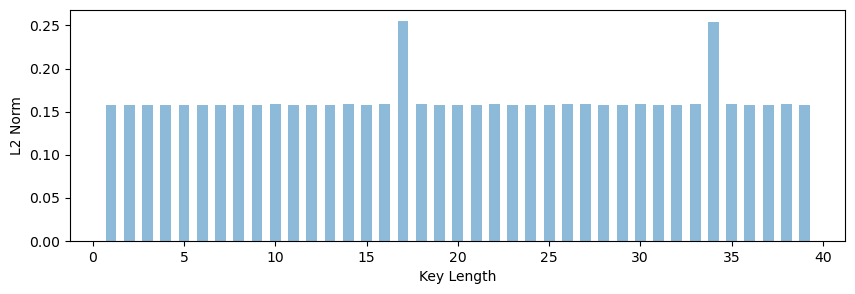

In [24]:
plt.subplots(figsize=(10, 3))
plt.xlabel('Key Length')
plt.ylabel('L2 Norm')
plt.bar([n for _, n in L2norms], [p for p, _ in L2norms], width=0.6, alpha=0.5);

#### Determine Each Byte of the Key

Now that the key length $n$ is known, 

1. Look at every $n$<sup>th</sup> character of the ciphertext starting with the $i$<sup>th</sup> character $c_i$. We call this the $i$<sup>th</sup> ciphertext **stream**. All bytes in this stream were generated by XOR'ing the plaintext with the same byte of the key.

2. Try decrypting the stream $B$ using every possible byte value $b \in [\text{0x00}, \ldots, \text{0xFF}]$ to get a candidate plaintext stream $M$.

3. When a guess $M$ is correct, then all bytes $m_i$ in the plaintext stream will be $32 < m_i < 127$ and the frequencies of all lowercase letters should be close to known letter distribution.

Restore the `17` characters key using a cipher text of `100` characters length:

In [25]:
attack.restore_key(determined_key_length, ciphertext[:100])

'H`(%`"3(ee)%a`@ "'

Restore the `17` characters key using a cipher text of `1000` characters length:

In [26]:
attack.restore_key(determined_key_length, ciphertext[:1000])

'a very secret key'

Which length of the ciphertext is required to fully restore the `17` characters long key?

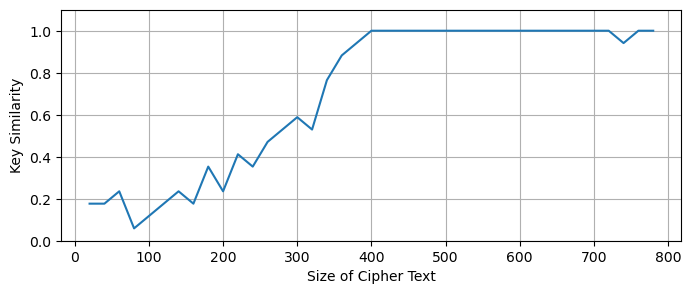

In [27]:
ciphertext_size = []
similarity = []

for s in range(20, 800, 20):
    restored_key = attack.restore_key(determined_key_length, ciphertext[:s])
    ciphertext_size.append(s)
    similarity.append(difflib.SequenceMatcher(a='a very secret key', b=restored_key).ratio())

plt.subplots(figsize=(8, 3))
plt.ylim(0, 1.1)
plt.grid()
plt.xlabel('Size of Cipher Text')
plt.ylabel('Key Similarity')
plt.plot(ciphertext_size, similarity);

### Course Exercise

Given the following cipher text from the Coursera course, let's try to decrypt it:

In [28]:
ciphertext = '''
F96DE8C227A259C87EE1DA2AED57C93FE5DA36ED4EC87EF2C63AAE5B9A7EFFD673BE4ACF7BE8923CAB1ECE7AF2DA3DA44FCF7AE29235A24
C963FF0DF3CA3599A70E5DA36BF1ECE77F8DC34BE129A6CF4D126BF5B9A7CFEDF3EB850D37CF0C63AA2509A76FF9227A55B9A6FE3D720A8
50D97AB1DD35ED5FCE6BF0D138A84CC931B1F121B44ECE70F6C032BD56C33FF9D320ED5CDF7AFF9226BE5BDE3FF7DD21ED56CF71F5C036A
94D963FF8D473A351CE3FE5DA3CB84DDB71F5C17FED51DC3FE8D732BF4D963FF3C727ED4AC87EF5DB27A451D47EFD9230BF47CA6BFEC12A
BE4ADF72E29224A84CDF3FF5D720A459D47AF59232A35A9A7AE7D33FB85FCE7AF5923AA31EDB3FF7D33ABF52C33FF0D673A551D93FFCD33
DA35BC831B1F43CBF1EDF67F0DF23A15B963FE5DA36ED68D378F4DC36BF5B9A7AFFD121B44ECE76FEDC73BE5DD27AFCD773BA5FC93FE5DA
3CB859D26BB1C63CED5CDF3FE2D730B84CDF3FF7DD21ED5ADF7CF0D636BE1EDB79E5D721ED57CE3FE6D320ED57D469F4DC27A85A963FF3C
727ED49DF3FFFDD24ED55D470E69E73AC50DE3FE5DA3ABE1EDF67F4C030A44DDF3FF5D73EA250C96BE3D327A84D963FE5DA32B91ED36BB1
D132A31ED87AB1D021A255DF71B1C436BF479A7AF0C13AA14794'''

ciphertext = ciphertext.replace('\n', '')
ciphertext = [ciphertext[i:i+2] for i in range(0, len(ciphertext), 2)]

In [29]:
attack = VariantVigenereCipherAttack()
determined_key_length, L2norms = attack.determine_key_length(ciphertext, max_key_length=22)

print(f'Determined key length: {determined_key_length}')

Determined key length: 21


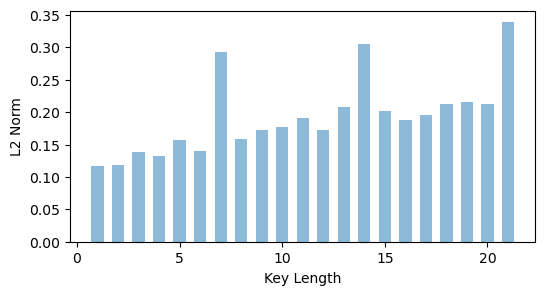

In [30]:
plt.subplots(figsize=(6, 3))
plt.xlabel('Key Length')
plt.ylabel('L2 Norm')
plt.bar([n for _, n in L2norms], [p for p, _ in L2norms], width=0.6, alpha=0.5);

we choose a key length of `7`

In [31]:
key = [hex(ord(c)) for c in attack.restore_key(7, ciphertext)]
key

['0xba', '0x1f', '0x91', '0xb2', '0x53', '0xcd', '0x3e']

In [32]:
cipher = VariantVigenereCipher(key)
cipher.dec(ciphertext)

'Cryptography is the practice and study of techniques for, among other things, secure communication in the presence of attackers. Cryptography has been used for hundreds, if not thousands, of years, but traditional cryptosystems were designed and evaluated in a fairly ad hoc manner. For example, the Vigenere encryption scheme was thought to be secure for decades after it was invented, but we now know, and this exercise demonstrates, that it can be broken very easily.'

## One-Time Pad Cipher

The one-time pad **encryption scheme** is the following:

* $\textbf{M} = \{0, 1\}^n$

* $\text{Gen}$: choose an uniform **key** $k \in \{0, 1\}^n$.

* $\text{Enc}_k(m) = k \oplus m$

* $\text{Dec}_k(c) = k \oplus c$

<br>

**Data Representation**:

1. The **plaintext** file is represented in ASCII

2. The **key** file and **ciphertext** file is represented in **hex-digits** written in ASCII

In [33]:
import secrets
from textwrap import wrap

class OneTimePadCipher:
    def gen(self, length):
        '''
        returns hex-digits representation of the key, e.g. 'eb2fb5fd85114e72eabddcbc'
        '''
        key = secrets.token_hex(length)
        return key
    
    def enc(self, plaintext, key = None):
        '''
        expects non encoded plaintext in ascii. if nor key is given, then a key is generated
        returns hex-digits representation of the key and the ciphertext, e.g. '48656c6c6f20576f726c6421'
        '''
        if not key:
            key = self.gen(len(plaintext))
        text = [hex(ord(c))[2:].zfill(2) for c in plaintext]
        ciphertext = [hex(int(m, 16) ^ int(k, 16))[2:].zfill(2) for m, k in zip(text, wrap(key, 2))]
        return key, ''.join(ciphertext)

    def dec(self, key, ciphertext):
        '''
        expects hex-digits representation of the key and the ciphertext
        returns plaintext
        '''
        plaintext = [hex(int(c, 16) ^ int(k, 16))[2:] for c, k in zip(wrap(ciphertext, 2), wrap(key, 2))]
        return "".join([chr(int(t, 16)) for t in plaintext])

In [34]:
cipher = OneTimePadCipher()
key, ciphertext = cipher.enc('Hello World!')
key, ciphertext

('05ce70e880099ca551ca63aa', '4dab1c84ef29cbca23a6078b')

In [35]:
plaintext = cipher.dec(key, ciphertext)
plaintext

'Hello World!'

### Course Exercise

Given the following seven ciphertexts, each of which was generated by encrypting some 31-character ASCII plaintext with the **one-time pad** using the **same key**

In [2]:
ciphers = [
    "BB3A65F6F0034FA957F6A767699CE7FABA855AFB4F2B520AEAD612944A801E",
    "BA7F24F2A35357A05CB8A16762C5A6AAAC924AE6447F0608A3D11388569A1E",
    "A67261BBB30651BA5CF6BA297ED0E7B4E9894AA95E300247F0C0028F409A1E",
    "A57261F5F0004BA74CF4AA2979D9A6B7AC854DA95E305203EC8515954C9D0F",
    "BB3A70F3B91D48E84DF0AB702ECFEEB5BC8C5DA94C301E0BECD241954C831E",
    "A6726DE8F01A50E849EDBC6C7C9CF2B2A88E19FD423E0647ECCB04DD4C9D1E",
    "BC7570BBBF1D46E85AF9AA6C7A9CEFA9E9825CFD5E3A0047F7CD009305A71E"
]

Let's try to decrypt it by leveraging the **ASCII-exploit** of the **one-time pad** and some **guessing**:

In [11]:
from textwrap import wrap

def xor(a, b):
    return [format(int(int(a, 16) ^ int(b, 16)), '08b') for a, b in zip(wrap(a, 2), wrap(b, 2))]

def is_letter(b):
    return True if (b >= 65 and b <= 90) or (b >= 97 and b <= 122) or (b == 0) else False

key = {}
for i in range(0, len(ciphers)):
    letters = {}
    for j in range(0, len(ciphers)):
        if j == i:
            continue
        tmp = xor(ciphers[i], ciphers[j])
        for k in range(0, len(tmp)):
            if is_letter(int(tmp[k], 2)):
                if k in letters:
                    letters[k] = letters[k] + 1
                else:
                    letters[k] = 1
    letters = {k: v for k, v in letters.items() if v >= (len(ciphers) - 2)}    # only if spaces at least in 5 other messages
    for k in letters.keys():
        key[k] = int(ciphers[i][2*k:2*k+2], 16) ^ ord(' ')

In [12]:
for cipher in ciphers:
    print(''.join([chr(int(c, 16) ^ key[i]) if i in key else '⬚' for i, c in enumerate(wrap(cipher, 2))]))

⬚ am p⬚a⬚n⬚ng a s⬚cr⬚t missio⬚ 
⬚e is ⬚h⬚ ⬚nly pe⬚so⬚ to trus⬚ 
⬚he cu⬚r⬚n⬚ plan ⬚s ⬚op secre⬚ 
⬚hen s⬚o⬚l⬚ we me⬚t ⬚o do thi⬚1
⬚ thin⬚ ⬚h⬚y shou⬚d ⬚ollow hi⬚ 
⬚his i⬚ ⬚u⬚er tha⬚ t⬚at one i⬚ 
⬚ot on⬚ ⬚a⬚et is ⬚et⬚er than ⬚ 


In [13]:
# iteratively guessing and adjusting the key
key[0] = int(wrap(ciphers[0], 2)[0], 16) ^ ord('I')    # first letter in first cipher is probably an 'I'
key[6] = int(wrap(ciphers[5], 2)[6], 16) ^ ord('s')    # ...
key[8] = int(wrap(ciphers[0], 2)[8], 16) ^ ord('n')
key[10] = int(wrap(ciphers[0], 2)[10], 16) ^ ord('i')
key[17] = int(wrap(ciphers[0], 2)[17], 16) ^ ord('e')
key[20] = int(wrap(ciphers[0], 2)[20], 16) ^ ord('e')
key[29] = int(wrap(ciphers[0], 2)[29], 16) ^ ord('n')
key[30] = int(wrap(ciphers[3], 2)[30], 16) ^ ord('?')

In [14]:
for cipher in ciphers:
    print(''.join([chr(int(c, 16) ^ key[i]) if i in key else '⬚' for i, c in enumerate(wrap(cipher, 2))]))

I am planning a secret mission.
He is the only person to trust.
The current plan is top secret.
When should we meet to do this?
I think they should follow him.
This is purer than that one is.
Not one cadet is better than I.
